<a href="https://colab.research.google.com/github/Abhishekai1/Physics-Informed-Neural-Networks-PINNs-/blob/main/PINN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Device: cpu


Adam L=6.581e+00 | f=2.98e-01 ic=1.20e-01 bc=3.88e-02 e=0.00e+00: 100%|██████████| 6000/6000 [1:12:01<00:00,  1.39it/s]


Training complete.


Baseline quick train: 100%|██████████| 2000/2000 [15:03<00:00,  2.21it/s]


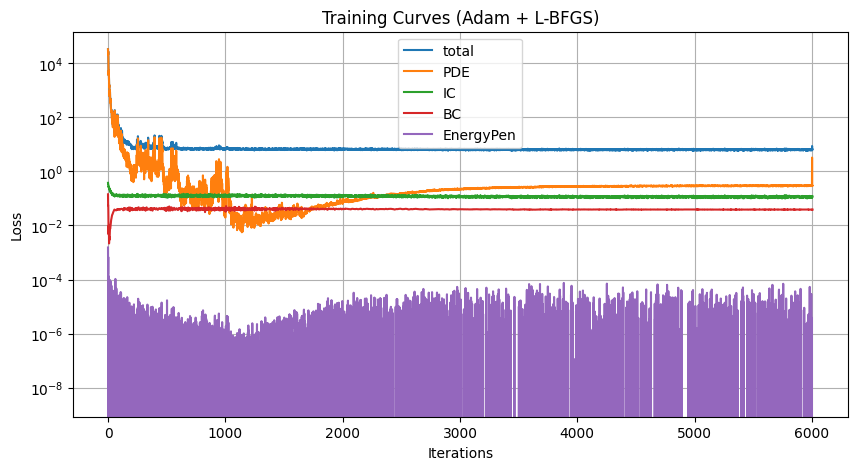

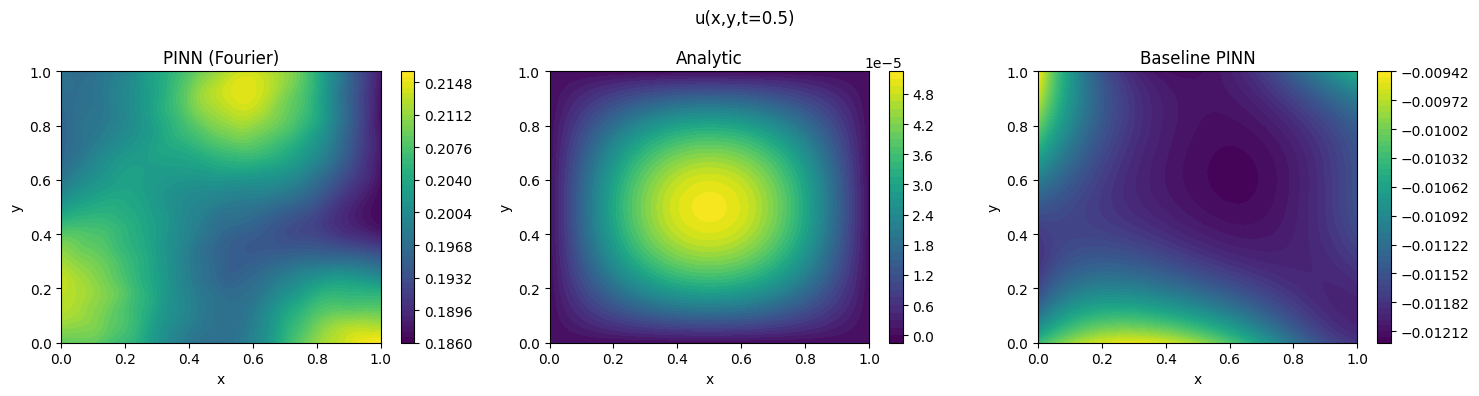

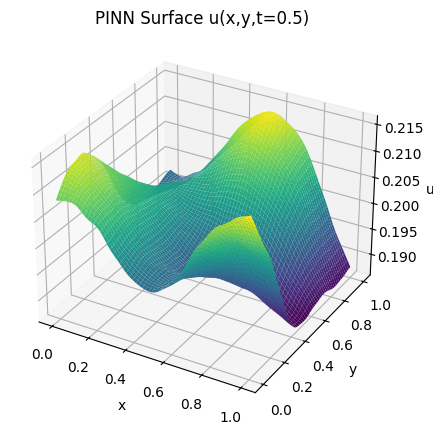

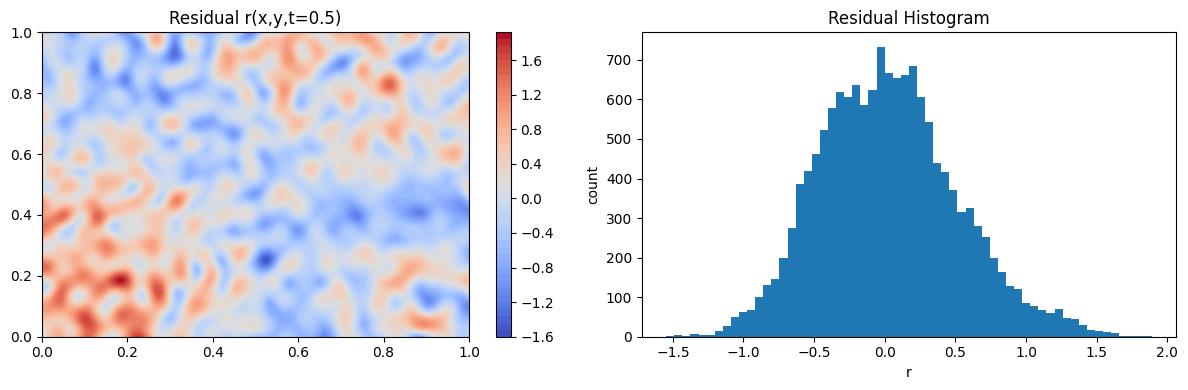

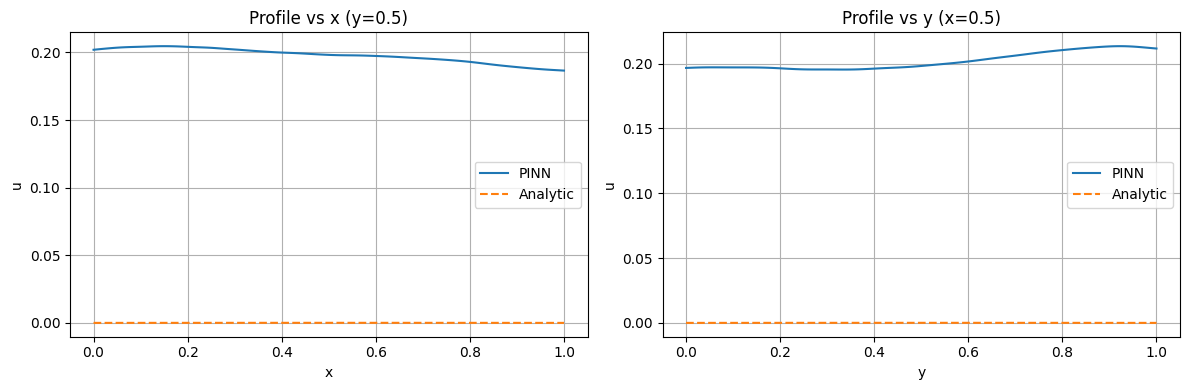

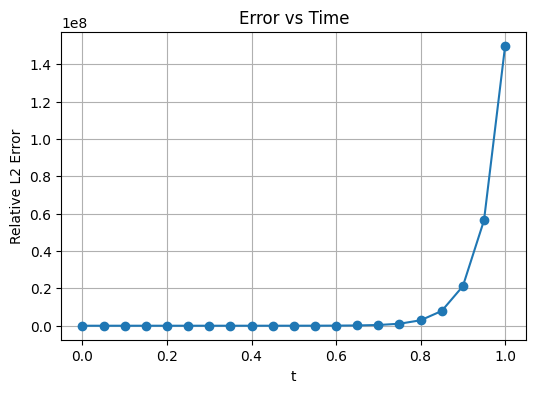

Saved animation: /content/pinn_heat_solution.gif


In [ ]:
# ============================================================
# PINN for 2D Heat Equation (Hard Mode, Many Visualizations)
# u_t = α (u_xx + u_yy),  (x,y,t) in [0,1]^2 x [0,1]
# IC: u(x,y,0) = sin(πx) sin(πy)
# BC: u=0 on ∂Ω
# Closed-form: u(x,y,t) = exp(-2π^2 α t) sin(πx) sin(πy)
# ============================================================

# STEP 0: INSTALLS
!pip install --quiet torch numpy matplotlib tqdm imageio imageio-ffmpeg

import math, os, io, time, imageio
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 (needed for 3D)
from tqdm import trange

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

# ----- Problem parameters -----
ALPHA = 1.0       # diffusivity
DOMAIN = [0.,1.,0.,1.,0.,1.]  # x in [0,1], y in [0,1], t in [0,1]

# ----- Analytic solution for given IC & alpha -----
def u_analytic(x, y, t, alpha=ALPHA):
    # x,y,t tensors (N,1)
    return torch.exp(-2*(math.pi**2)*alpha*t) * torch.sin(math.pi*x) * torch.sin(math.pi*y)


# ============================================================
# STEP 1: Positional Encoding (Fourier features) + MLP
# ============================================================
class FourierFeatures(nn.Module):
    def __init__(self, in_dim=3, num_frequencies=6):
        super().__init__()
        self.B = nn.Parameter(torch.randn(in_dim, num_frequencies)*2.0, requires_grad=False)
        # Feature: [sin(2πBx), cos(2πBx)]
    def forward(self, xyz):  # (N,3)
        # xyz @ B -> (N, num_frequencies)
        proj = 2*math.pi*xyz @ self.B  # (N, F)
        return torch.cat([torch.sin(proj), torch.cos(proj)], dim=-1)  # (N, 2F)

class MLP(nn.Module):
    def __init__(self, in_dim, hidden=128, depth=6, out_dim=1, act=nn.Tanh):
        super().__init__()
        layers = []
        dims = [in_dim] + [hidden]* (depth-1) + [out_dim]
        for i in range(len(dims)-2):
            layers += [nn.Linear(dims[i], dims[i+1]), act()]
        layers += [nn.Linear(dims[-2], dims[-1])]
        self.net = nn.Sequential(*layers)
        for m in self.net:
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                nn.init.zeros_(m.bias)
    def forward(self, x):
        return self.net(x)

class PINN(nn.Module):
    def __init__(self, use_fourier=True, num_frequencies=6, hidden=128, depth=6):
        super().__init__()
        self.use_fourier = use_fourier
        self.ff = FourierFeatures(3, num_frequencies) if use_fourier else None
        in_dim = 3 if not use_fourier else (2*num_frequencies)
        self.mlp = MLP(in_dim=in_dim, hidden=hidden, depth=depth, out_dim=1, act=nn.Tanh)
    def forward(self, x, y, t):
        base = torch.cat([x,y,t], dim=1)  # (N,3)
        if self.use_fourier:
            base = self.ff(base)           # (N,2F)
        return self.mlp(base)

model = PINN(use_fourier=True, num_frequencies=8, hidden=128, depth=6).to(device)

# Baseline (for comparison, no Fourier features)
baseline = PINN(use_fourier=False, hidden=128, depth=6).to(device)

# ============================================================
# STEP 2: Automatic differentiation residual for PDE
# ============================================================
def pde_residual(model, x, y, t, alpha=ALPHA):
    x.requires_grad_(True)
    y.requires_grad_(True)
    t.requires_grad_(True)
    u = model(x,y,t)
    ones = torch.ones_like(u)

    u_t  = torch.autograd.grad(u, t, grad_outputs=ones, create_graph=True)[0]
    u_x  = torch.autograd.grad(u, x, grad_outputs=ones, create_graph=True)[0]
    u_xx = torch.autograd.grad(u_x, x, grad_outputs=torch.ones_like(u_x), create_graph=True)[0]
    u_y  = torch.autograd.grad(u, y, grad_outputs=ones, create_graph=True)[0]
    u_yy = torch.autograd.grad(u_y, y, grad_outputs=torch.ones_like(u_y), create_graph=True)[0]

    return u_t - alpha*(u_xx + u_yy)

# ============================================================
# STEP 3: Data sampling (collocation / IC / BC) + curriculum
# ============================================================
def sample_collocation(N):
    # Curriculum: bias t more densely early, uniform later (mix two)
    t_mix = torch.cat([
        torch.rand(int(0.5*N),1)**2,      # concentrate near 0 early
        torch.rand(N - int(0.5*N),1)
    ], dim=0)
    x = torch.rand(N,1)
    y = torch.rand(N,1)
    return x.to(device), y.to(device), t_mix.to(device)

def sample_ic(N):
    x = torch.rand(N,1)
    y = torch.rand(N,1)
    t = torch.zeros_like(x)
    u = torch.sin(math.pi*x)*torch.sin(math.pi*y)
    return x.to(device), y.to(device), t.to(device), u.to(device)

def sample_bc(N):
    # Sample points on boundary: x=0/1 or y=0/1 with random partners
    n = N//4
    x0 = torch.zeros(n,1); x1 = torch.ones(n,1)
    y0 = torch.zeros(n,1); y1 = torch.ones(n,1)
    xr = torch.rand(n,1);  yr = torch.rand(n,1)
    xb = torch.cat([xr, xr, x0, x1], dim=0)
    yb = torch.cat([y0, y1, yr, yr], dim=0)
    tb = torch.rand(4*n,1)
    ub = torch.zeros(4*n,1)
    return xb.to(device), yb.to(device), tb.to(device), ub.to(device)

# ============================================================
# STEP 4: Losses (PDE, IC, BC) + Energy-decay penalty
# ============================================================
def energy(u, x, y):
    # approximate ∫ u^2 dxdy by mean over samples (unit square)
    return torch.mean(u**2)

def energy_decay_penalty(model, n_pairs=256, dt=1e-2):
    # Sample (x,y,t), enforce E(t+dt) <= E(t)
    x = torch.rand(n_pairs,1, device=device)
    y = torch.rand(n_pairs,1, device=device)
    t = torch.rand(n_pairs,1, device=device)*(1.0-dt)

    u_t   = model(x,y,t)
    u_tdt = model(x,y,t+dt)

    # Estimate energies via Monte Carlo averages
    # We reuse the same (x,y) set as a proxy (cheap). For robustness, resample more points if needed.
    E_t   = energy(u_t, x, y)
    E_tdt = energy(u_tdt, x, y)
    return torch.relu(E_tdt - E_t)  # penalize if energy increased

def loss_components(model, Nf, Nic, Nbc, w_pde, w_ic, w_bc, w_e):
    Xf, Yf, Tf = sample_collocation(Nf)
    Xic, Yic, Tic, Uic = sample_ic(Nic)
    Xbc, Ybc, Tbc, Ubc = sample_bc(Nbc)

    res = pde_residual(model, Xf, Yf, Tf)
    mse_f  = torch.mean(res**2)

    u_ic = model(Xic, Yic, Tic)
    mse_ic = torch.mean((u_ic - Uic)**2)

    u_bc = model(Xbc, Ybc, Tbc)
    mse_bc = torch.mean((u_bc - Ubc)**2)

    e_pen = energy_decay_penalty(model, n_pairs=512)

    total = w_pde*mse_f + w_ic*mse_ic + w_bc*mse_bc + w_e*e_pen
    return total, (mse_f.detach(), mse_ic.detach(), mse_bc.detach(), e_pen.detach())

# ============================================================
# STEP 5: Training (Adam -> L-BFGS) with adaptive reweighting
# ============================================================
# Hyperparams
Nf, Nic, Nbc = 6000, 800, 1600
w_pde, w_ic, w_bc, w_e = 1.0, 50.0, 50.0, 1.0   # start weights
EPOCHS_ADAM = 6000
EPOCHS_LBFGS = 500

adam = optim.Adam(model.parameters(), lr=1e-3)
sched = ReduceLROnPlateau(adam, factor=0.5, patience=400, verbose=True)
grad_clip = 1.0

history = {"total": [], "pde": [], "ic": [], "bc": [], "e": []}

def adaptive_weights(mse_f, mse_ic, mse_bc, e_pen, eps=1e-12):
    # Simple normalization so each term has similar scale (not full GradNorm, but effective)
    vals = torch.tensor([mse_f, mse_ic, mse_bc, e_pen], device=device)
    inv = 1.0/(vals + eps)
    inv = inv/torch.sum(inv)
    # Keep IC/BC dominant but adapt a bit
    alpha = 0.2
    base = torch.tensor([1.0, 50.0, 50.0, 1.0], device=device)
    new = (1-alpha)*base + alpha*(inv*torch.sum(base))
    return new[0].item(), new[1].item(), new[2].item(), new[3].item()

# ----- Adam phase -----
pbar = trange(EPOCHS_ADAM)
for ep in pbar:
    adam.zero_grad()
    loss, (lf, lic, lbc, le) = loss_components(model, Nf, Nic, Nbc, w_pde, w_ic, w_bc, w_e)
    loss.backward()
    torch.nn.utils.clip_grad_norm_(model.parameters(), grad_clip)
    adam.step()
    sched.step(loss.detach())
    # adapt weights every 200 steps
    if (ep+1) % 200 == 0:
        w_pde, w_ic, w_bc, w_e = adaptive_weights(lf, lic, lbc, le)

    history["total"].append(loss.item())
    history["pde"].append(lf.item())
    history["ic"].append(lic.item())
    history["bc"].append(lbc.item())
    history["e"].append(le.item())
    pbar.set_description(f"Adam L={loss.item():.3e} | f={lf.item():.2e} ic={lic.item():.2e} bc={lbc.item():.2e} e={le.item():.2e}")

# ----- L-BFGS refine -----
lbfgs = optim.LBFGS(model.parameters(), lr=1.0, max_iter=EPOCHS_LBFGS, max_eval=None, tolerance_grad=1e-9, tolerance_change=1e-12, history_size=100, line_search_fn="strong_wolfe")
def closure():
    lbfgs.zero_grad()
    loss, (lf, lic, lbc, le) = loss_components(model, Nf, Nic, Nbc, w_pde, w_ic, w_bc, w_e)
    loss.backward()
    history["total"].append(loss.item())
    history["pde"].append(lf.item())
    history["ic"].append(lic.item())
    history["bc"].append(lbc.item())
    history["e"].append(le.item())
    return loss
lbfgs.step(closure)

print("Training complete.")

# ============================================================
# STEP 6: Baseline model (quick train) for comparison (no Fourier)
# ============================================================
baseline_adam = optim.Adam(baseline.parameters(), lr=1e-3)
for _ in trange(2000, desc="Baseline quick train"):
    baseline_adam.zero_grad()
    loss_b, _ = loss_components(baseline, 4000, 400, 800, 1.0, 50.0, 50.0, 0.0)
    loss_b.backward()
    baseline_adam.step()

# ============================================================
# STEP 7: Evaluation Grid + Visualizations
# ============================================================
def eval_on_grid(model, t_val=0.5, n=121):
    x = torch.linspace(0,1,n, device=device).unsqueeze(1)
    y = torch.linspace(0,1,n, device=device).unsqueeze(1)
    X, Y = torch.meshgrid(x.squeeze(), y.squeeze(), indexing='ij')
    T = torch.full_like(X, fill_value=t_val)
    U = model(X.reshape(-1,1), Y.reshape(-1,1), T.reshape(-1,1)).detach().cpu().numpy()
    return X.detach().cpu().numpy(), Y.detach().cpu().numpy(), U.reshape(n,n)

def eval_residual_map(model, t_val=0.5, n=121):
    x = torch.linspace(0,1,n, device=device).unsqueeze(1)
    y = torch.linspace(0,1,n, device=device).unsqueeze(1)
    X, Y = torch.meshgrid(x.squeeze(), y.squeeze(), indexing='ij')
    T = torch.full_like(X, fill_value=t_val)
    res = pde_residual(model, X.reshape(-1,1), Y.reshape(-1,1), T.reshape(-1,1)).detach().cpu().numpy()
    return X.detach().cpu().numpy(), Y.detach().cpu().numpy(), res.reshape(n,n)

def rel_l2(pred, truth):
    num = torch.linalg.norm(pred-truth)
    den = torch.linalg.norm(truth) + 1e-12
    return (num/den).item()

# --- Plot training curves ---
plt.figure(figsize=(10,5))
plt.semilogy(history["total"], label="total")
plt.semilogy(history["pde"], label="PDE")
plt.semilogy(history["ic"],  label="IC")
plt.semilogy(history["bc"],  label="BC")
plt.semilogy(history["e"],   label="EnergyPen")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.title("Training Curves (Adam + L-BFGS)")
plt.legend(); plt.grid(True); plt.show()

# --- Field at t=0.5 (ours vs analytic vs baseline) ---
nvis = 121
Xg, Yg, U_pred = eval_on_grid(model, t_val=0.5, n=nvis)
_,   _, U_base = eval_on_grid(baseline, t_val=0.5, n=nvis)

x_t = torch.tensor(Xg, device=device)
y_t = torch.tensor(Yg, device=device)
t_t = torch.full_like(x_t, 0.5)
U_true = u_analytic(x_t.reshape(-1,1), y_t.reshape(-1,1), t_t.reshape(-1,1)).reshape(nvis,nvis).detach().cpu().numpy()

fig = plt.figure(figsize=(15,4))
for i,(Z,title) in enumerate([(U_pred,"PINN (Fourier)"),
                              (U_true,"Analytic"),
                              (U_base,"Baseline PINN")]):
    ax = fig.add_subplot(1,3,i+1)
    cf = ax.contourf(Xg, Yg, Z, 50, cmap="viridis")
    fig.colorbar(cf, ax=ax)
    ax.set_title(title); ax.set_xlabel("x"); ax.set_ylabel("y")
plt.suptitle("u(x,y,t=0.5)"); plt.tight_layout(); plt.show()

# --- 3D Surface for our model ---
fig = plt.figure(figsize=(6,5))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(Xg, Yg, U_pred, rstride=2, cstride=2, cmap=cm.viridis, linewidth=0, antialiased=True)
ax.set_title("PINN Surface u(x,y,t=0.5)")
ax.set_xlabel('x'); ax.set_ylabel('y'); ax.set_zlabel('u'); plt.show()

# --- Residual maps & histogram ---
Xr, Yr, Rmap = eval_residual_map(model, t_val=0.5, n=nvis)
plt.figure(figsize=(12,4))
ax1 = plt.subplot(1,2,1)
cf = ax1.contourf(Xr, Yr, Rmap, 50, cmap="coolwarm")
plt.colorbar(cf, ax=ax1); ax1.set_title("Residual r(x,y,t=0.5)")
ax2 = plt.subplot(1,2,2)
plt.hist(Rmap.ravel(), bins=60)
plt.title("Residual Histogram"); plt.xlabel("r"); plt.ylabel("count")
plt.tight_layout(); plt.show()

# --- Profiles along x at y=0.5 and y along x=0.5 ---
mid = nvis//2
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(Xg[:,mid], U_pred[:,mid], label="PINN")
plt.plot(Xg[:,mid], U_true[:,mid], '--', label="Analytic")
plt.title("Profile vs x (y=0.5)"); plt.xlabel("x"); plt.ylabel("u"); plt.legend(); plt.grid(True)

plt.subplot(1,2,2)
plt.plot(Yg[mid,:], U_pred[mid,:], label="PINN")
plt.plot(Yg[mid,:], U_true[mid,:], '--', label="Analytic")
plt.title("Profile vs y (x=0.5)"); plt.xlabel("y"); plt.ylabel("u"); plt.legend(); plt.grid(True)
plt.tight_layout(); plt.show()

# --- Relative error over time curve ---
times = torch.linspace(0,1,21, device=device)
errs = []
for tt in times:
    x = torch.linspace(0,1,121, device=device).unsqueeze(1)
    y = torch.linspace(0,1,121, device=device).unsqueeze(1)
    X, Y = torch.meshgrid(x.squeeze(), y.squeeze(), indexing='ij')
    T = torch.full_like(X, fill_value=tt.item())
    U_p = model(X.reshape(-1,1), Y.reshape(-1,1), T.reshape(-1,1))
    U_t = u_analytic(X.reshape(-1,1), Y.reshape(-1,1), T.reshape(-1,1))
    errs.append(rel_l2(U_p, U_t))
plt.figure(figsize=(6,4))
plt.plot(times.detach().cpu().numpy(), errs, marker='o')
plt.xlabel("t"); plt.ylabel("Relative L2 Error"); plt.title("Error vs Time")
plt.grid(True); plt.show()

# ============================================================
# STEP 8: Time Animation (t from 0 to 1)
# ============================================================
frames_t = np.linspace(0, 1, 40)
gif_path = "/content/pinn_heat_solution.gif"

imgs = []
for tt in frames_t:
    _, _, U = eval_on_grid(model, t_val=float(tt), n=121)
    fig = plt.figure(figsize=(5,4))
    cf = plt.contourf(Xg, Yg, U, 50, cmap="viridis")
    plt.title(f"PINN u(x,y,t={tt:.2f})"); plt.xlabel("x"); plt.ylabel("y")
    buf = io.BytesIO()
    plt.savefig(buf, format='png', dpi=120, bbox_inches='tight')
    plt.close(fig)
    buf.seek(0)
    imgs.append(imageio.v2.imread(buf))

imageio.mimsave(gif_path, imgs, duration=0.12)
print("Saved animation:", gif_path)

# ============================================================
# DONE.
# Tips:
# - Increase Nf/Nic/Nbc for higher accuracy (with GPU).
# - Turn off Fourier features to see baseline limitations.
# - Try different ICs by changing u(x,y,0) and analytic solution accordingly.
# ============================================================
